In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import network
from numba import jit, njit, double, int8, int64
from numba_progress import ProgressBar

# Aufgabe 6 
> Zielsetzung:
- Einfluss von Wechselwirkungsenergien untersuchen: Graduelles Abkühlen für $J_{ij} = -3 = \epsilon$ analog zu ex 5,
- Berechnung bzw. Auftragung der Spezifischen Wärme $C(T) = \epsilon^2 \frac{\langle n^2 \rangle - \langle n \rangle ^2}{NT^2}$,
- Analytischer Ausdruck der inneren Energie $E(\langle n \rangle)$,
- Dauer für metastabilen Zustand bei T = 1,
- Dauer für metastabilen Zustand bei T = 1 für zufälliges Vorzeichen $J_{ij} = \pm 3$. 

> Durchführung der Monte-Carlo-Simulation mit annealing für Temperaturabhängigkeiten von Energie, Größe und spezifischer Wärme des Proteins bei $J_{ij} = -3$:

In [24]:
@njit(nogil=True)
def monte_carlo_temperature(protein, temperature_0, temperature_1, number_of_steps, number_of_repeats, progress_proxy):
    
    temperature = np.linspace(temperature_0, temperature_1, number_of_steps)
    simulation = np.zeros(shape=(number_of_steps, 3), dtype=double)
  
    for step in range(number_of_steps):
        energy_mean = 0
        size_mean = 0
        n = 0
        n_squared = 0
        for temperature_step in range(number_of_repeats):
            
            protein.random_fold_step(temperature[step])
            energy_mean += protein.calc_energy()
            size_mean += protein.calc_size()
            n += protein.calc_next_neighbors()
            n_squared += n ** 2
            progress_proxy.update(1)
        
        n /= number_of_repeats
        n_squared /= number_of_repeats
        
        energy_mean /= number_of_repeats
        size_mean /= number_of_repeats
        
        simulation[step][0] = energy_mean
        simulation[step][1] = size_mean
        simulation[step][2] = 0.3 * (n_squared - n ** 2) / (temperature[step] ** 2)
        
    return simulation

steps = 100
repeats = 1000000
num_iterations = steps * repeats
T_0 = 10
T_1 = 1
p = network.create_protein(interaction_type='const')
with ProgressBar(total=num_iterations) as progress:
    arr_T = monte_carlo_temperature(p, T_0, T_1, steps, repeats, progress)
energy = arr_T[:, 0]
size = arr_T[:, 1]
capacity = arr_T[:, 2]

  0%|          | 0/100000000 [00:00<?, ?it/s]

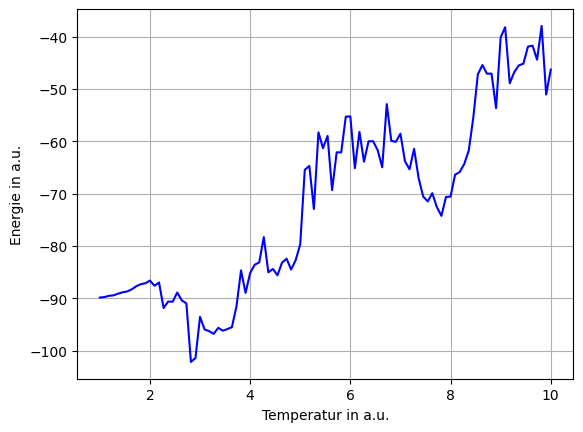

In [25]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Energie in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), energy, color='blue')

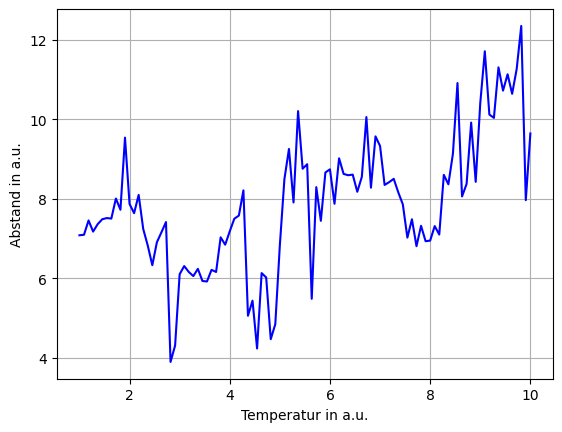

In [26]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Abstand in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), size, color='blue')

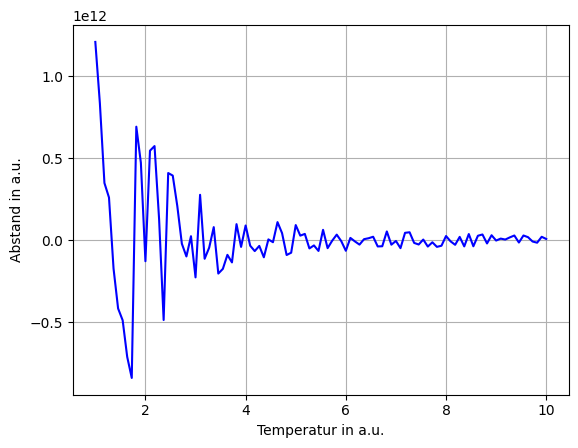

In [27]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Abstand in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), capacity, color='blue')